# Image data sets

In [ ]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import corner
import logging
import torch

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
from experiments.datasets import FFHQStyleGAN2DLoader
from experiments.architectures.image_transforms import create_image_transform
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow

# for key in logging.Logger.manager.loggerDict:
#     if "architectures" not in key and "manifold_flow" not in key:
#         logging.getLogger(key).setLevel(logging.WARNING)

## Options

In [ ]:
highres = False
transform = False


## Transform images to numpy arrays (only need to do this once)

In [3]:
def load_pngs(filename, range_):
    imgs = np.array([plt.imread(f"../data/samples/gan2d/{filename}.png".format(i)).astype(np.float) for i in range_])
    imgs = np.transpose(imgs, [0,3,1,2])  # Want (batch, c, h, w)
    return imgs

if transform:
    np.save("../data/samples/gan2d/grid.npy", load_pngs("grid/grid_64_{:04}", range(81)))
    np.save("../data/samples/gan2d/grid_highres.npy", load_pngs("grid/grid_1024_{:04}", range(81)))
    np.save("../data/samples/gan2d/train.npy", load_pngs("train_test/subspace_64_{:05}", range(1, 10001)))
    np.save("../data/samples/gan2d/train_highres.npy", load_pngs("train_test/subspace_1024_{:05}", range(1, 101)))
    np.save("../data/samples/gan2d/test.npy", load_pngs("train_test/subspace_64_{:05}", range(10001, 11001)))


## Load MF model

In [6]:
def load_model(
    filename,
    outerlayers=12,
    innerlayers=4,
    levels=4,
    splinebins=6,
    splinerange=3.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=True,
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="linear",
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        2,
        innerlayers,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.01,
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [7]:
mf = load_model("mf_2_gan2d_april")

## Plot images corresponding to 2D grid in GAN latent space

In [42]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
gan_zs = np.vstack(each_grid).T

In [43]:
gan_images = np.load("../data/samples/gan2d/grid{}.npy".format("_highres" if highres else ""))
gan_images.shape

(81, 3, 64, 64)

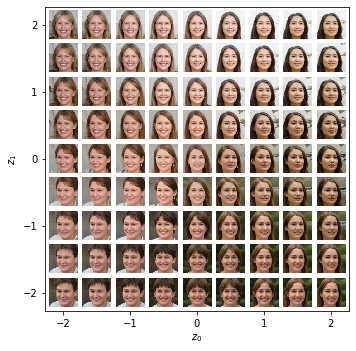

In [46]:
size = 0.42
fig = plt.figure(figsize=(5,5))

for z, image in zip(gan_zs, gan_images):
    image_ = np.transpose(image, [1,2,0])
    plt.imshow(image_, extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.ylabel("$z_1$")
plt.xlabel("$z_0$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.tight_layout()
plt.savefig("../figures/gan2d_grid.pdf", dpi=600)
    

## Samples from MF

In [8]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
mf_zs = np.vstack(each_grid).T

In [9]:
z_ = torch.tensor(mf_zs, dtype=torch.float)
mf_images = mf.sample(u=z_, n=resolution**2).detach().numpy()
mf_images.shape


torch.Size([81, 2])


(81, 3, 64, 64)

18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:27 matplotlib.image               WARNING Clipping input data to th

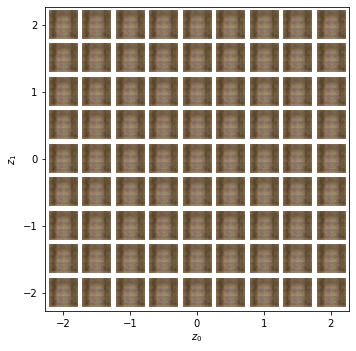

In [13]:
size = 0.42
fig = plt.figure(figsize=(5,5))

for z, image in zip(mf_zs, mf_images):
    image_ = np.transpose(image, [1,2,0]) / 256.
    plt.imshow(image_, extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.ylabel("$z_1$")
plt.xlabel("$z_0$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.tight_layout()
plt.savefig("../figures/gan2d_mf_grid.pdf", dpi=600)
    

## Debug MF linear layer

In [18]:
preproc =  mf.outer_transform._transforms[0]
conv = mf.outer_transform._transforms[1]
lin = mf.outer_transform._transforms[2]

In [42]:
loader = FFHQStyleGAN2DLoader()
data = loader.load_dataset(train=True, dataset_dir="../data/samples/gan2d")
x = data[1][0]
x = x.unsqueeze(0).to(torch.float)
x.size(), x

(torch.Size([1, 3, 64, 64]),
 tensor([[[[160.2458, 160.0521, 160.6178,  ..., 162.4247, 163.5682, 165.0293],
           [160.3377, 160.9396, 160.9149,  ..., 162.8141, 163.9335, 163.8512],
           [161.7917, 161.6875, 161.0560,  ..., 162.2640, 163.8827, 163.5989],
           ...,
           [162.3669, 163.1697, 166.8948,  ..., 120.7847, 115.4324, 139.5490],
           [162.8509, 163.3259, 165.1631,  ..., 123.4950, 123.9952, 133.4852],
           [164.3677, 166.6495, 169.4103,  ..., 118.6453, 134.5990, 127.4351]],
 
          [[158.0597, 158.9875, 157.7242,  ..., 161.8094, 162.6628, 163.8967],
           [158.7322, 158.4032, 158.6630,  ..., 162.0292, 162.1528, 161.9617],
           [159.4210, 159.6160, 159.6499,  ..., 162.3413, 162.9052, 161.8713],
           ...,
           [164.8399, 163.1062, 166.4531,  ...,  75.1628,  70.3923,  85.0591],
           [164.2229, 164.3186, 165.6278,  ...,  77.2047,  77.3795,  84.0651],
           [164.4597, 165.1794, 166.0709,  ...,  73.0442,  86.7687,

In [43]:
x_preprocessed = preproc.forward(x)[0]
x_preprocessed.size(), x_preprocessed


(torch.Size([1, 3, 64, 64]),
 tensor([[[[ 0.1260,  0.1252,  0.1274,  ...,  0.1345,  0.1389,  0.1446],
           [ 0.1263,  0.1287,  0.1286,  ...,  0.1360,  0.1404,  0.1400],
           [ 0.1320,  0.1316,  0.1291,  ...,  0.1338,  0.1402,  0.1391],
           ...,
           [ 0.1342,  0.1374,  0.1519,  ..., -0.0282, -0.0491,  0.0451],
           [ 0.1361,  0.1380,  0.1452,  ..., -0.0176, -0.0156,  0.0214],
           [ 0.1421,  0.1510,  0.1618,  ..., -0.0365,  0.0258, -0.0022]],
 
          [[ 0.1174,  0.1210,  0.1161,  ...,  0.1321,  0.1354,  0.1402],
           [ 0.1200,  0.1188,  0.1198,  ...,  0.1329,  0.1334,  0.1327],
           [ 0.1227,  0.1235,  0.1236,  ...,  0.1341,  0.1363,  0.1323],
           ...,
           [ 0.1439,  0.1371,  0.1502,  ..., -0.2064, -0.2250, -0.1677],
           [ 0.1415,  0.1419,  0.1470,  ..., -0.1984, -0.1977, -0.1716],
           [ 0.1424,  0.1452,  0.1487,  ..., -0.2147, -0.1611, -0.1916]],
 
          [[ 0.0943,  0.0954,  0.0975,  ...,  0.1113,  0.

In [44]:
x_convoluted = conv.forward(x_preprocessed)[0]
x_convoluted.size(), x_convoluted


(torch.Size([1, 12288]),
 tensor([[ 4.3403e-02, -2.5664e-03, -4.5330e-02,  ..., -9.1418e+00,
           2.9858e+00, -5.6306e+00]], grad_fn=<CatBackward>))

In [57]:
x_linear = lin.forward(x_convoluted)[0]
x_linear.size(), x_linear
# ", ".join([f"{x:.1f}" for x in x_linear.detach().numpy().flatten()])


(torch.Size([1, 12288]),
 tensor([[-2.4055,  1.1205, -0.6350,  ..., -0.0206,  0.0676,  0.2797]],
        grad_fn=<AddBackward0>))

In [58]:
x_proj = mf.projection(x_linear)[0]
x_proj.size(), x_proj

(torch.Size([1, 2]), tensor([[-2.4055,  1.1205]], grad_fn=<SliceBackward>))

## Training samples

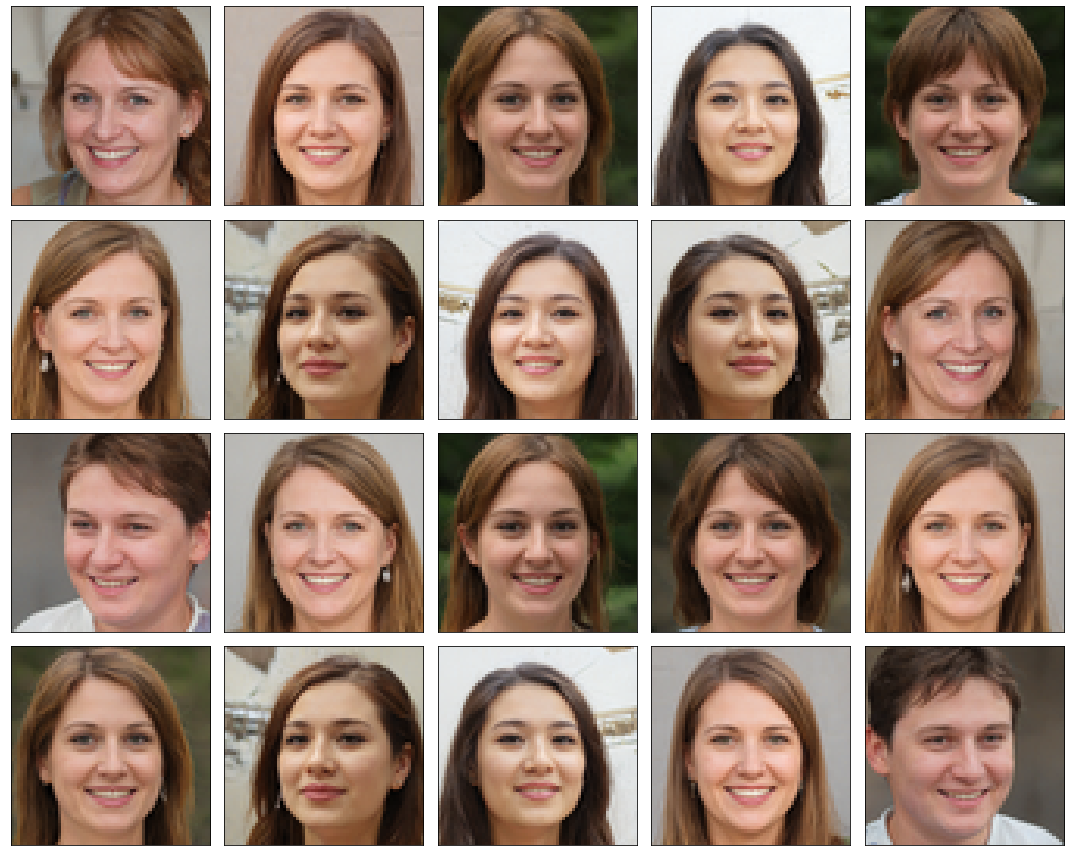

In [48]:
loader = FFHQStyleGAN2DLoader()
data = loader.load_dataset(train=True, dataset_dir="../data/samples/gan2d")
    
fig = plt.figure(figsize=(5*3., 4*3.))

for i in range(20):
    x, _ = data[np.random.randint(len(data) - 1)]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
